# Introduction

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Files
train.csv - the training dataset; stroke is the binary target
test.csv - the test dataset; your objective is to predict the probability of positive stroke
sample_submission.csv - a sample submission file in the correct format

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [151]:
df = pd.read_csv(r'C:\Users\ekrsinh\OneDrive - Ericsson\Documents\Modelling_other\Tabular Playground Series\Playground Series Season 3, Episode 2\train.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [152]:
df_copy = df

In [153]:
test = pd.read_csv(r'C:\Users\ekrsinh\OneDrive - Ericsson\Documents\Modelling_other\Tabular Playground Series\Playground Series Season 3, Episode 2\test.csv')
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


## Understanding the data

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [155]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

No missing data

Data Imbalance check

In [156]:
df['stroke'].value_counts(normalize = True)*100

0    95.870361
1     4.129639
Name: stroke, dtype: float64

So, the data is imbalanced and needs balancing.

In [157]:
df['gender'].value_counts(normalize = True)*100

Female    61.722426
Male      38.271040
Other      0.006534
Name: gender, dtype: float64

In [158]:
df['hypertension'].value_counts(normalize = True)*100

0    95.027444
1     4.972556
Name: hypertension, dtype: float64

In [159]:
df['heart_disease'].value_counts(normalize = True)*100

0    97.667277
1     2.332723
Name: heart_disease, dtype: float64

In [160]:
df['ever_married'].value_counts(normalize = True)*100

Yes    67.858076
No     32.141924
Name: ever_married, dtype: float64

In [161]:
df['work_type'].value_counts(normalize = True)*100

Private          63.721903
children         13.316780
Self-employed    12.669890
Govt_job         10.016989
Never_worked      0.274438
Name: work_type, dtype: float64

In [162]:
df['Residence_type'].value_counts(normalize = True)*100

Rural    50.078411
Urban    49.921589
Name: Residence_type, dtype: float64

In [163]:
df['smoking_status'].value_counts(normalize = True)*100

never smoked       41.041558
Unknown            29.685050
formerly smoked    15.270518
smokes             14.002875
Name: smoking_status, dtype: float64

## Visualising the Data

In [164]:
#df of categorical variable
df_num = df.select_dtypes(include = ['float','int64'])
df_num.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0,28.0,0,0,79.53,31.1,0
1,1,33.0,0,0,78.44,23.9,0
2,2,42.0,0,0,103.00,40.3,0
3,3,56.0,0,0,64.87,28.8,0
4,4,24.0,0,0,73.36,28.8,0


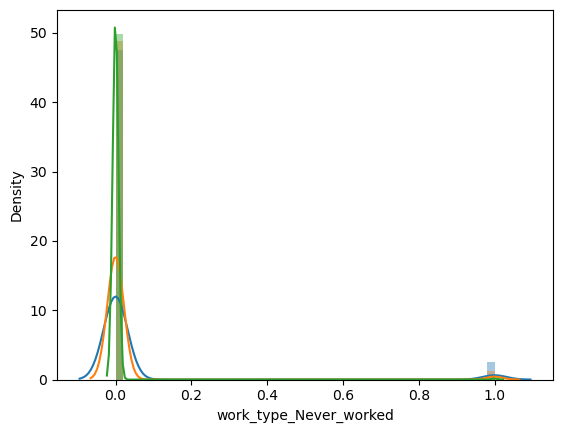

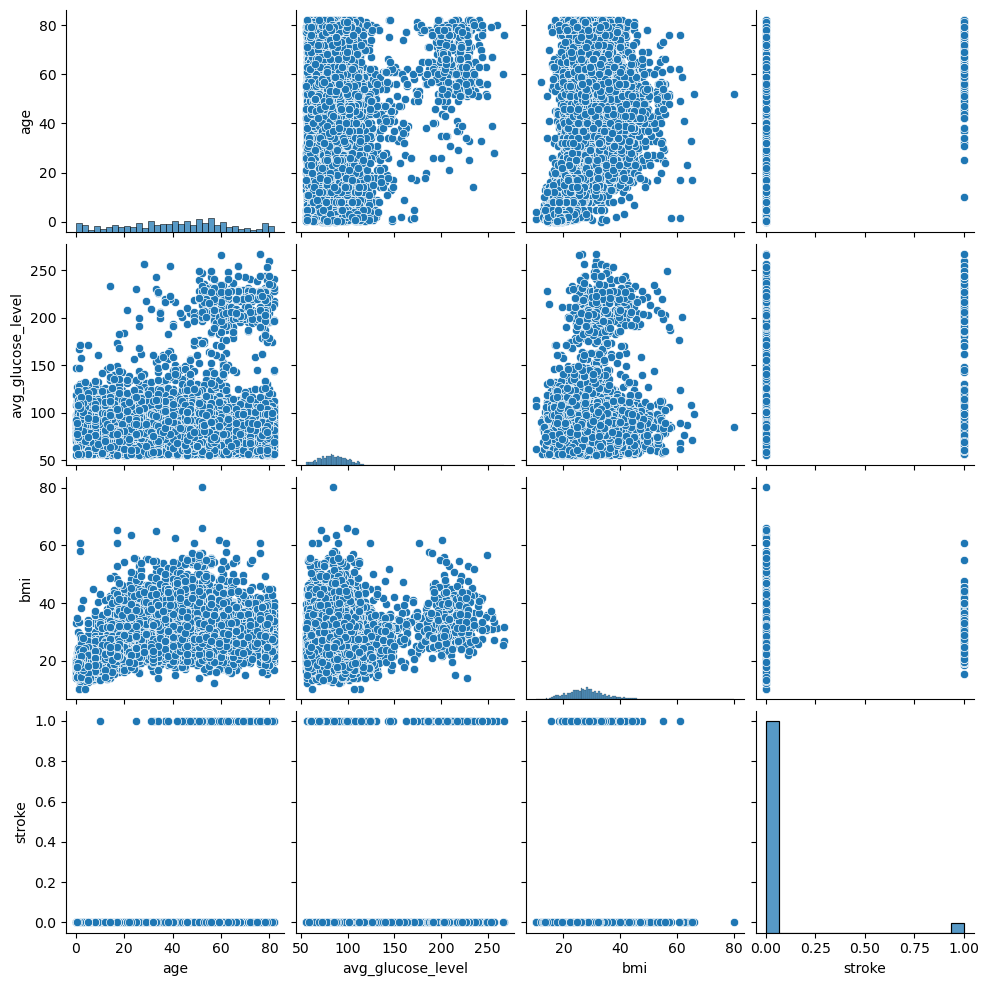

In [165]:
sns.pairplot(df[['age','avg_glucose_level','bmi','stroke']])
plt.show();

## Observation : 
    1. Glucose level is higher for aged people
    2. Glucose level is higher for obese(higher bmi) people
    3. Stroke chances are more for people having higher bmi
    

In [166]:
# Distribution of age
sns.distplot(df['age'])

<AxesSubplot:xlabel='age', ylabel='Density'>

So, In Age variable, there is no outliers and looking normal

In [167]:
# Distribution of avg_glucose_leve
sns.distplot(df['avg_glucose_level'])

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Density'>

## Checking for Outliers

In [168]:
df.describe(percentiles = [0.25,0.5,0.75,0.90,0.95,0.99])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
90%,13772.700000,70.000000,0.000000,0.000000,108.797000,36.700000,0.000000
95%,14537.850000,78.000000,0.000000,0.000000,118.123500,40.200000,0.000000
99%,15149.970000,81.000000,1.000000,1.000000,217.778800,46.900000,1.000000


Looks like there is no outliers

In [169]:
#creating dataframe of categorical variables 
df_cat = df.select_dtypes(exclude = ['float','int64'])
df_cat.head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,never smoked
1,Male,Yes,Private,Rural,formerly smoked
2,Female,Yes,Private,Rural,Unknown
3,Male,Yes,Private,Urban,never smoked
4,Female,No,Private,Rural,never smoked


## Correlation Check 

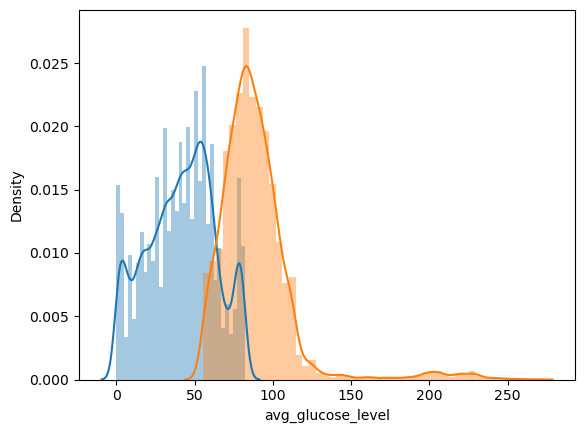

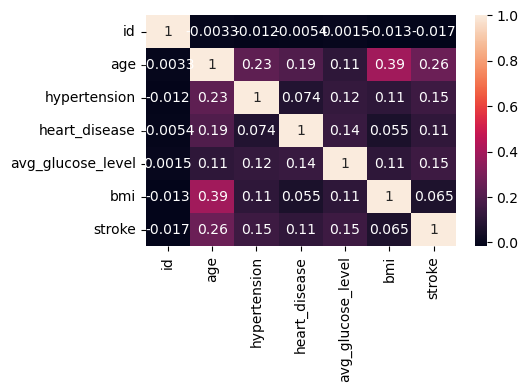

In [170]:
plt.figure(figsize = (5,3))
sns.heatmap(df.corr(),annot = True)
plt.show();

Obervation : 
1. There is high correlation between aga and bmi
2. Age followed by hypertension and avg glocose level correlation is high with stroke

# Data preprocessing

In [171]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [172]:
print(df['work_type'].value_counts(normalize = True)*100)
print(df['ever_married'].value_counts(normalize = True)*100)
print(df['Residence_type'].value_counts(normalize = True)*100)
print(df['smoking_status'].value_counts(normalize = True)*100)

Private          63.721903
children         13.316780
Self-employed    12.669890
Govt_job         10.016989
Never_worked      0.274438
Name: work_type, dtype: float64
Yes    67.858076
No     32.141924
Name: ever_married, dtype: float64
Rural    50.078411
Urban    49.921589
Name: Residence_type, dtype: float64
never smoked       41.041558
Unknown            29.685050
formerly smoked    15.270518
smokes             14.002875
Name: smoking_status, dtype: float64


In [173]:
df['gender'].value_counts()

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [174]:
#replace 'other' with 'Female'
df['gender'] = df['gender'].replace(to_replace='Other',value = 'Female')

In [175]:
df['gender'].value_counts()

Female    9447
Male      5857
Name: gender, dtype: int64

In [176]:
df['gender'] = df['gender'].map({'Male':1,'Female':0})

In [177]:
df['Residence_type'] = df['Residence_type'].map({'Urban':1,'Rural':0})

In [178]:
df['ever_married'] = df['ever_married'].map({'Yes':1,'No':0})

In [179]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,28.0,0,0,1,Private,1,79.53,31.1,never smoked,0
1,1,1,33.0,0,0,1,Private,0,78.44,23.9,formerly smoked,0
2,2,0,42.0,0,0,1,Private,0,103.00,40.3,Unknown,0
3,3,1,56.0,0,0,1,Private,1,64.87,28.8,never smoked,0
4,4,0,24.0,0,0,0,Private,0,73.36,28.8,never smoked,0


In [180]:
# Hot encoding multivariate categorical variables - 'work_type','smoking_status'
work_type_hot = pd.get_dummies(df['work_type'],prefix = 'work_type', drop_first=True)


In [181]:
df = pd.concat([df,work_type_hot],axis =1)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,0,1,28.0,0,0,1,Private,1,79.53,31.1,never smoked,0,0,1,0,0
1,1,1,33.0,0,0,1,Private,0,78.44,23.9,formerly smoked,0,0,1,0,0
2,2,0,42.0,0,0,1,Private,0,103.00,40.3,Unknown,0,0,1,0,0
3,3,1,56.0,0,0,1,Private,1,64.87,28.8,never smoked,0,0,1,0,0
4,4,0,24.0,0,0,0,Private,0,73.36,28.8,never smoked,0,0,1,0,0


In [182]:
# Drop 'work_type' as we have created the dummies for it

df.drop(['work_type'],axis = 1,inplace = True)

In [183]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,0,1,28.0,0,0,1,1,79.53,31.1,never smoked,0,0,1,0,0
1,1,1,33.0,0,0,1,0,78.44,23.9,formerly smoked,0,0,1,0,0
2,2,0,42.0,0,0,1,0,103.00,40.3,Unknown,0,0,1,0,0
3,3,1,56.0,0,0,1,1,64.87,28.8,never smoked,0,0,1,0,0
4,4,0,24.0,0,0,0,0,73.36,28.8,never smoked,0,0,1,0,0


In [184]:
df.isnull().sum()

id                         0
gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
Residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
dtype: int64

In [185]:
# Hot encoding multivariate categorical variables - 'smoking_status'
smoking_status_hot = pd.get_dummies(df['smoking_status'],prefix = 'smoking_status', drop_first=True)
df = pd.concat([df,smoking_status_hot],axis =1)
# Drop 'smoking_status' as we have created the dummies for it
df.drop(['smoking_status'],axis = 1,inplace = True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1,28.0,0,0,1,1,79.53,31.1,0,0,1,0,0,0,1,0
1,1,1,33.0,0,0,1,0,78.44,23.9,0,0,1,0,0,1,0,0
2,2,0,42.0,0,0,1,0,103.00,40.3,0,0,1,0,0,0,0,0
3,3,1,56.0,0,0,1,1,64.87,28.8,0,0,1,0,0,0,1,0
4,4,0,24.0,0,0,0,0,73.36,28.8,0,0,1,0,0,0,1,0


## Now we have all variables in numeric form suitable for modelling

#### Checking skewness in data over the index axis

In [186]:
skew = df.skew(axis = 0,skipna=True)
skew_df = pd.DataFrame(skew)
skew_df = skew_df.reset_index()
skew_df.columns = ['Feature','Skew']
skew_df

,Feature,Skew
0,id,0.000000
1,gender,0.482672
2,age,-0.103579
3,hypertension,4.143196
4,heart_disease,6.316649
5,ever_married,-0.764840
6,Residence_type,0.003137
7,avg_glucose_level,3.037242
8,bmi,0.713051
9,stroke,4.611121


In [187]:
sns.distplot(df['hypertension'])

<AxesSubplot:xlabel='hypertension', ylabel='Density'>

In [188]:
sns.distplot(df['heart_disease'])

<AxesSubplot:xlabel='heart_disease', ylabel='Density'>

In [189]:
sns.distplot(df['work_type_Never_worked'])

<AxesSubplot:xlabel='work_type_Never_worked', ylabel='Density'>

So, we see that few variables like 'work_type_Never_worked','heart_disease','hypertension' are skewed.skewness > 3 considered here.

In [190]:
X = df.drop(['id','stroke'],axis =1)

In [191]:
y = df['stroke']

### Feature scaling

In [192]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

In [193]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((12243, 15), (3061, 15), (12243,), (3061,))

In [194]:
#Logitic regression without class balancing
lr = LogisticRegression()
model1 = lr.fit(X_train,y_train)
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

#Let's check the overall accuracy
print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))

print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))

roc_auc_test  0.5106855103272707
roc_auc_train  0.5113134040789402


# Perform class balancing with:
    1.Random Oversampling
    2.SMOTE
    3.ADASYN`

### Random Oversampling

In [195]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over , y_Over = oversample.fit_resample(X_scaled,y)

### Train test split

In [196]:
X_train,X_test,y_train,y_test = train_test_split(X_over,y_Over,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((23475, 15), (5869, 15), (23475,), (5869,))

We can see that data count increased in all samples as new data added to balance the class.

## Model building

### Logistic Regression

In [197]:
lr = LogisticRegression()
model1 = lr.fit(X_train,y_train)
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

#Let's check the overall accuracy
print("roc_auc_test ",roc_auc_score(y_test,y_test_pred).round(3))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred).round(3))

roc_auc_test  0.81
roc_auc_train  0.808


# Class balancing with SMOT

In [198]:
# transform the dataset
oversample = SMOTE()
X_over , y_Over = oversample.fit_resample(X_scaled,y)
#Train-test split
X_train,X_test,y_train,y_test = train_test_split(X_over,y_Over,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((23475, 15), (5869, 15), (23475,), (5869,))

### Logistic Regression

In [199]:
lr = LogisticRegression()
model2 = lr.fit(X_train,y_train)
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

#Let's check the overall accuracy
print("roc_auc_test ",roc_auc_score(y_test,y_test_pred).round(3))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred).round(3))

roc_auc_test  0.819
roc_auc_train  0.814


# Class balancing with ADASYN

In [200]:
oversample = ADASYN()
X_over , y_Over = oversample.fit_resample(X_scaled,y)
#Train-test split
X_train,X_test,y_train,y_test = train_test_split(X_over,y_Over,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((23561, 15), (5891, 15), (23561,), (5891,))

### Logistic Regression

In [201]:
lr = LogisticRegression()
model3 = lr.fit(X_train,y_train)
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

#Let's check the overall accuracy
print("roc_auc_test ",roc_auc_score(y_test,y_test_pred).round(3))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred).round(3))

roc_auc_test  0.805
roc_auc_train  0.807


# Conclusion on oversampling :
SMOTE oversampling method giving better results than Random oversampling and ADASYS.So, we will further tune the model and apply different algorithm on data oversampled by SMOTE

In [202]:
# Class balancing with SMOT(Final)
oversample = SMOTE()
X_over , y_Over = oversample.fit_resample(X_scaled,y)
#Train-test split
X_train,X_test,y_train,y_test = train_test_split(X_over,y_Over,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((23475, 15), (5869, 15), (23475,), (5869,))

## Logistic Regression

In [203]:
lr = LogisticRegression()
model2 = lr.fit(X_train,y_train)
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

#Let's check the overall accuracy
print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))

roc_auc_test  0.8159361816753705
roc_auc_train  0.8143271842307968


In [55]:
#Hyperparameter tuning with GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1']
c_values = [5,3,1.0, 0.5,0.1, 0.01]

params = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
grid_search = GridSearchCV(estimator=model2, param_grid=params, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=100),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [5, 3, 1.0, 0.5, 0.1, 0.01],
                         'penalty': ['l2', 'l1'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [56]:
print(grid_search.best_estimator_)

LogisticRegression(solver='liblinear')


In [57]:
print(grid_search.best_params_)

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


In [58]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))

roc_auc_test  0.811241525958254
roc_auc_train  0.8143176790209907


### Slight improvement observed after parameter tuning

## RandomForest

In [59]:
rf = RandomForestClassifier()
model3 = rf.fit(X_train,y_train)
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

#Let's check the overall accuracy
print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))


roc_auc_test  0.9441682586168004
roc_auc_train  1.0


In [60]:
#Hyperparameter tuning with GridSearchCV

max_depth = [20,30,40,50]
n_estimators = [400,500,700]

params = dict(max_depth=max_depth,n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
grid_search = GridSearchCV(estimator=model3, param_grid=params, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=100),
             error_score=0, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40, 50],
                         'n_estimators': [400, 500, 700]},
             scoring='roc_auc')

In [61]:
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=50, n_estimators=500)


In [62]:
print(grid_search.best_params_)

{'max_depth': 50, 'n_estimators': 500}


In [63]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))

roc_auc_test  0.9455655273623762
roc_auc_train  1.0


In [ ]:
This further improves the model : roc_auc_test  0.9455655273623762

## XGBoost

In [208]:
xgb = XGBClassifier()
model4 = xgb.fit(X_train,y_train)
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))

roc_auc_test  0.9684430878698395
roc_auc_train  0.9824411917859249


So, here with just base model of XGBoost, we are getting very good roc_auc score : train -0.9824411917859249, test-0.9684430878698395
We will further tune with GridSearchCV to see if further model can be improved.

In [209]:
#Hyperparameter tuning with GridSearchCV
params = {
    'n_estimators' : [200,400,500,600],
    'max_depth'    :[10,30,50,60],
    'learning_rate' : [0.1,0.2,0.3]
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=100)
grid_search = GridSearchCV(estimator= model4, param_grid= params, scoring= 'roc_auc', n_jobs= -1,cv = cv,error_score=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=100),
             error_score=0,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwi...
                                     max_cat_threshold=64, max_cat_to_onehot=4,
                                     max_delta_step=0, max_depth=6,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                     

In [210]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=50, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [211]:
print(grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 50, 'n_estimators': 600}


In [212]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("roc_auc_test ",roc_auc_score(y_test,y_test_pred))
print("roc_auc_train ",roc_auc_score(y_train,y_train_pred))

roc_auc_test  0.9714503112927517
roc_auc_train  1.0


So, XGBoost with tuned hyperparameters have very good roc_aus score among all models:test :0.9714503112927517,train-1.0.

# Test

### Perform preprocessing steps as in train dataset(df)

In [269]:
test = pd.read_csv(r'C:\Users\ekrsinh\OneDrive - Ericsson\Documents\Modelling_other\Tabular Playground Series\Playground Series Season 3, Episode 2\test.csv')
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [270]:
test.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [271]:
print(test['work_type'].value_counts(normalize = True)*100)
print(test['ever_married'].value_counts(normalize = True)*100)
print(test['Residence_type'].value_counts(normalize = True)*100)
print(test['smoking_status'].value_counts(normalize = True)*100)

Private          64.415915
Self-employed    13.220306
children         12.446100
Govt_job          9.721678
Never_worked      0.196002
Name: work_type, dtype: float64
Yes    69.315955
No     30.684045
Name: ever_married, dtype: float64
Urban    50.784006
Rural    49.215994
Name: Residence_type, dtype: float64
never smoked       41.522932
Unknown            29.165033
formerly smoked    15.523324
smokes             13.788710
Name: smoking_status, dtype: float64


In [272]:
test['gender'].value_counts()

Female    6338
Male      3865
Other        1
Name: gender, dtype: int64

In [273]:
#replace 'other' with 'Female'
test['gender'] = test['gender'].replace(to_replace='Other',value = 'Female')

In [274]:
test['gender'].value_counts()

Female    6339
Male      3865
Name: gender, dtype: int64

In [275]:
test['gender'] = test['gender'].map({'Male':1,'Female':0})

In [276]:
test['Residence_type'] = test['Residence_type'].map({'Urban':1,'Rural':0})

In [277]:
test['ever_married'] = test['ever_married'].map({'Yes':1,'No':0})

In [278]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,0,57.0,0,0,1,Private,0,82.54,33.4,Unknown
1,15305,1,70.0,1,0,1,Private,1,72.06,28.5,Unknown
2,15306,0,5.0,0,0,0,children,1,103.72,19.5,Unknown
3,15307,0,56.0,0,0,1,Govt_job,1,69.24,41.4,smokes
4,15308,1,32.0,0,0,1,Private,0,111.15,30.1,smokes


In [279]:
# Hot encoding multivariate categorical variables - 'work_type','smoking_status'
work_type_hot = pd.get_dummies(test['work_type'],prefix = 'work_type', drop_first=True)


In [280]:
test = pd.concat([test,work_type_hot],axis =1)
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,15304,0,57.0,0,0,1,Private,0,82.54,33.4,Unknown,0,1,0,0
1,15305,1,70.0,1,0,1,Private,1,72.06,28.5,Unknown,0,1,0,0
2,15306,0,5.0,0,0,0,children,1,103.72,19.5,Unknown,0,0,0,1
3,15307,0,56.0,0,0,1,Govt_job,1,69.24,41.4,smokes,0,0,0,0
4,15308,1,32.0,0,0,1,Private,0,111.15,30.1,smokes,0,1,0,0


In [281]:
# Drop 'work_type' as we have created the dummies for it

test.drop(['work_type'],axis = 1,inplace = True)

In [282]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,15304,0,57.0,0,0,1,0,82.54,33.4,Unknown,0,1,0,0
1,15305,1,70.0,1,0,1,1,72.06,28.5,Unknown,0,1,0,0
2,15306,0,5.0,0,0,0,1,103.72,19.5,Unknown,0,0,0,1
3,15307,0,56.0,0,0,1,1,69.24,41.4,smokes,0,0,0,0
4,15308,1,32.0,0,0,1,0,111.15,30.1,smokes,0,1,0,0


In [283]:
test.isnull().sum()

id                         0
gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
Residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
dtype: int64

In [284]:
# Hot encoding multivariate categorical variables - 'smoking_status'
smoking_status_hot = pd.get_dummies(test['smoking_status'],prefix = 'smoking_status', drop_first=True)
test = pd.concat([test,smoking_status_hot],axis =1)
# Drop 'smoking_status' as we have created the dummies for it
test.drop(['smoking_status'],axis = 1,inplace = True)
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,15304,0,57.0,0,0,1,0,82.54,33.4,0,1,0,0,0,0,0
1,15305,1,70.0,1,0,1,1,72.06,28.5,0,1,0,0,0,0,0
2,15306,0,5.0,0,0,0,1,103.72,19.5,0,0,0,1,0,0,0
3,15307,0,56.0,0,0,1,1,69.24,41.4,0,0,0,0,0,0,1
4,15308,1,32.0,0,0,1,0,111.15,30.1,0,1,0,0,0,0,1


## Now we have all variables in numeric form suitable for modelling

In [285]:
test_copy = test

In [286]:
test = test.drop(['id'],axis =1)

In [287]:
scaler = MinMaxScaler()

test_scaled = scaler.fit_transform(test)

## Prediction on test data

In [365]:
y_test_pred = best_model.predict_proba(test_scaled)

In [366]:
y_test_pred

array([[9.9940324e-01, 5.9679075e-04],
       [9.4476444e-01, 5.5235568e-02],
       [9.9998701e-01, 1.2967828e-05],
       ...,
       [9.9999350e-01, 6.5187978e-06],
       [9.9998164e-01, 1.8366103e-05],
       [9.9999338e-01, 6.6273542e-06]], dtype=float32)

In [367]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.columns = ['Negative_prob','Stroke']
y_pred_1.head()

,Negative_prob,Stroke
0,0.999403,0.000597
1,0.944764,0.055236
2,0.999987,0.000013
3,0.922606,0.077394
4,0.999246,0.000754


In [368]:
y_pred_1 = y_pred_1.drop(['Negative_prob'],axis =1)
y_pred_1.head()

,Stroke
0,0.000597
1,0.055236
2,0.000013
3,0.077394
4,0.000754


In [370]:
test_data = test_copy[['id']]

In [371]:
type(test_data)

pandas.core.frame.DataFrame

In [372]:
submission = pd.concat([test_data,y_pred_1],axis =1)

# Submission data

In [374]:
submission.to_csv(r'C:\Users\ekrsinh\OneDrive - Ericsson\Documents\Modelling_other\Tabular Playground Series\Playground Series Season 3, Episode 2\submission.csv', index=False)
submission.head(10)

,id,Stroke
0,15304,0.000597
1,15305,0.055236
2,15306,0.000013
3,15307,0.077394
4,15308,0.000754
5,15309,0.000091
6,15310,0.000051
7,15311,0.002056
8,15312,0.000015
9,15313,0.000252
